# Processing the results of the experiment

In [46]:
import importlib
import utils
importlib.reload(utils) # Reload instead of using cached version

import warnings
warnings.filterwarnings('ignore')

# Imports
import pandas as pd
import glob
from pathlib import Path
import os
import subprocess
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from functools import reduce

!python3 --version

Python 3.10.1


## Setup

In [47]:
# Set root to git subfolder
git_root = subprocess.check_output(['git', 'rev-parse', '--show-toplevel']).decode('utf-8').strip()
os.chdir(git_root)

In [48]:
RESULT_DIR = "experiments/FYP-results/OFFICIAL_2"

We first extract results from all the trials

In [49]:
get_root_name = lambda path : path.split("/")[-2]

df = pd.DataFrame()

# Loop through all the search algorithms
search_algorithms = glob.glob(RESULT_DIR + "/*/")
for search_algorithm in search_algorithms:
    rl_algorithms = glob.glob(search_algorithm + "/*/")
    for rl_algorithm in rl_algorithms:
        trial_numbers = glob.glob(rl_algorithm + "/*/")
        for trial_number in trial_numbers:
            path_log = trial_number + "logs/"
            new_row = pd.DataFrame([{"search_algorithm": get_root_name(search_algorithm), "rl_algorithm": get_root_name(rl_algorithm), "trial_number": get_root_name(trial_number).split("_")[-1], "path_log": path_log}])
            df = pd.concat([df, new_row], ignore_index=True)
df

search_algorithm         rl_algorithm trial_number  \
0    FYPLocalSearch  ProbabilityMatching            2   
1    FYPLocalSearch  ProbabilityMatching            3   
2    FYPLocalSearch  ProbabilityMatching            4   
3    FYPLocalSearch  ProbabilityMatching            1   
4    FYPLocalSearch  ProbabilityMatching            0   
5    FYPLocalSearch        EpsilonGreedy            2   
6    FYPLocalSearch        EpsilonGreedy            3   
7    FYPLocalSearch        EpsilonGreedy            4   
8    FYPLocalSearch        EpsilonGreedy            1   
9    FYPLocalSearch        EpsilonGreedy            0   
10   FYPLocalSearch                  UCB            2   
11   FYPLocalSearch                  UCB            3   
12   FYPLocalSearch                  UCB            4   
13   FYPLocalSearch                  UCB            1   
14   FYPLocalSearch                  UCB            0   
15   FYPLocalSearch      UniformSelector            2   
16   FYPLocalSearch      UniformSelector            3   
17   FYPLocalSearch      UniformSelector            4   
18   FYPLocalSearch      UniformSelector            1   
19   FYPLocalSearch      UniformSelector            0   

                                                                               path_log  
0   experiments/FYP-results/OFFICIAL_2/FYPLocalSearch/ProbabilityMatching/trial_2/logs/  
1   experiments/FYP-results/OFFICIAL_2/FYPLocalSearch/ProbabilityMatching/trial_3/logs/  
2   experiments/FYP-results/OFFICIAL_2/FYPLocalSearch/ProbabilityMatching/trial_4/logs/  
3   experiments/FYP-results/OFFICIAL_2/FYPLocalSearch/ProbabilityMatching/trial_1/logs/  
4   experiments/FYP-results/OFFICIAL_2/FYPLocalSearch/ProbabilityMatching/trial_0/logs/  
5         experiments/FYP-results/OFFICIAL_2/FYPLocalSearch/EpsilonGreedy/trial_2/logs/  
6         experiments/FYP-results/OFFICIAL_2/FYPLocalSearch/EpsilonGreedy/trial_3/logs/  
7         experiments/FYP-results/OFFICIAL_2/FYPLocalSearch/EpsilonGreedy/trial_4/logs/  
8         experiments/FYP-results/OFFICIAL_2/FYPLocalSearch/EpsilonGreedy/trial_1/logs/  
9         experiments/FYP-results/OFFICIAL_2/FYPLocalSearch/EpsilonGreedy/trial_0/logs/  
10                  experiments/FYP-results/OFFICIAL_2/FYPLocalSearch/UCB/trial_2/logs/  
11                  experiments/FYP-results/OFFICIAL_2/FYPLocalSearch/UCB/trial_3/logs/  
12                  experiments/FYP-results/OFFICIAL_2/FYPLocalSearch/UCB/trial_4/logs/  
13                  experiments/FYP-results/OFFICIAL_2/FYPLocalSearch/UCB/trial_1/logs/  
14                  experiments/FYP-results/OFFICIAL_2/FYPLocalSearch/UCB/trial_0/logs/  
15      experiments/FYP-results/OFFICIAL_2/FYPLocalSearch/UniformSelector/trial_2/logs/  
16      experiments/FYP-results/OFFICIAL_2/FYPLocalSearch/UniformSelector/trial_3/logs/  
17      experiments/FYP-results/OFFICIAL_2/FYPLocalSearch/UniformSelector/trial_4/logs/  
18      experiments/FYP-results/OFFICIAL_2/FYPLocalSearch/UniformSelector/trial_1/logs/  
19      experiments/FYP-results/OFFICIAL_2/FYPLocalSearch/UniformSelector/trial_0/logs/

## Preprocessing

In [50]:
# Extract Pickle Object
df['pkl_obj'] = df['path_log'].apply(utils.generate_pickle_object)
# df['pkl_obj'].iloc[0] # Example of what the pickle object looks like

In [51]:
# Extract some common columns we might need
df['diff'] = df['pkl_obj'].apply(lambda x: x['diff'])
df['initial_fitness'] = df['pkl_obj'].apply(lambda x: x['initial_fitness'])
df['best_fitness'] = df['pkl_obj'].apply(lambda x: x['best_fitness'])
df['patch'] = df['path_log'].apply(utils.get_patch)

In [52]:
df['num_variants_evaluated'] = df['pkl_obj'].apply(utils.get_num_variants_evaluated) 
df['num_successful_variants_evaluated'] = df['pkl_obj'].apply(utils.get_num_successful_variants_evaluated)
df['get_unique_statuses'] = df['pkl_obj'].apply(utils.get_unique_statuses)

df['num_unique_variants_evaluated'] = df['pkl_obj'].apply(utils.get_num_unique_variants_evaluated)
df['num_unique_successful_variants_evaluated'] = df['pkl_obj'].apply(lambda x : x['unique_successful_run'])

In [53]:
df['fitness_decrease_percentage'] = (df['best_fitness'] / df['initial_fitness']) * 100
df['successful_runs_percentage'] = (df['num_successful_variants_evaluated'] / df['num_variants_evaluated']) * 100

In [54]:
df['operator_selector'] = df['pkl_obj'].apply(lambda x: x['operator_selector'])

In [55]:
df['rewards'] = df['operator_selector'].apply(lambda x: np.array(x.reward_log))
df['cumulative_rewards'] = df['rewards'].apply(lambda x: np.cumsum(x))

In [56]:
df['average_reward_vs_time'] = df['rewards'].apply(utils.get_average_vs_time)

In [57]:
df

search_algorithm         rl_algorithm trial_number  \
0    FYPLocalSearch  ProbabilityMatching            2   
1    FYPLocalSearch  ProbabilityMatching            3   
2    FYPLocalSearch  ProbabilityMatching            4   
3    FYPLocalSearch  ProbabilityMatching            1   
4    FYPLocalSearch  ProbabilityMatching            0   
5    FYPLocalSearch        EpsilonGreedy            2   
6    FYPLocalSearch        EpsilonGreedy            3   
7    FYPLocalSearch        EpsilonGreedy            4   
8    FYPLocalSearch        EpsilonGreedy            1   
9    FYPLocalSearch        EpsilonGreedy            0   
10   FYPLocalSearch                  UCB            2   
11   FYPLocalSearch                  UCB            3   
12   FYPLocalSearch                  UCB            4   
13   FYPLocalSearch                  UCB            1   
14   FYPLocalSearch                  UCB            0   
15   FYPLocalSearch      UniformSelector            2   
16   FYPLocalSearch      UniformSelector            3   
17   FYPLocalSearch      UniformSelector            4   
18   FYPLocalSearch      UniformSelector            1   
19   FYPLocalSearch      UniformSelector            0   

                                                                               path_log  \
0   experiments/FYP-results/OFFICIAL_2/FYPLocalSearch/ProbabilityMatching/trial_2/logs/   
1   experiments/FYP-results/OFFICIAL_2/FYPLocalSearch/ProbabilityMatching/trial_3/logs/   
2   experiments/FYP-results/OFFICIAL_2/FYPLocalSearch/ProbabilityMatching/trial_4/logs/   
3   experiments/FYP-results/OFFICIAL_2/FYPLocalSearch/ProbabilityMatching/trial_1/logs/   
4   experiments/FYP-results/OFFICIAL_2/FYPLocalSearch/ProbabilityMatching/trial_0/logs/   
5         experiments/FYP-results/OFFICIAL_2/FYPLocalSearch/EpsilonGreedy/trial_2/logs/   
6         experiments/FYP-results/OFFICIAL_2/FYPLocalSearch/EpsilonGreedy/trial_3/logs/   
7         experiments/FYP-results/OFFICIAL_2/FYPLocalSearch/EpsilonGreedy/trial_4/logs/   
8         experiments/FYP-results/OFFICIAL_2/FYPLocalSearch/EpsilonGreedy/trial_1/logs/   
9         experiments/FYP-results/OFFICIAL_2/FYPLocalSearch/EpsilonGreedy/trial_0/logs/   
10                  experiments/FYP-results/OFFICIAL_2/FYPLocalSearch/UCB/trial_2/logs/   
11                  experiments/FYP-results/OFFICIAL_2/FYPLocalSearch/UCB/trial_3/logs/   
12                  experiments/FYP-results/OFFICIAL_2/FYPLocalSearch/UCB/trial_4/logs/   
13                  experiments/FYP-results/OFFICIAL_2/FYPLocalSearch/UCB/trial_1/logs/   
14                  experiments/FYP-results/OFFICIAL_2/FYPLocalSearch/UCB/trial_0/logs/   
15      experiments/FYP-results/OFFICIAL_2/FYPLocalSearch/UniformSelector/trial_2/logs/   
16      experiments/FYP-results/OFFICIAL_2/FYPLocalSearch/UniformSelector/trial_3/logs/   
17      experiments/FYP-results/OFFICIAL_2/FYPLocalSearch/UniformSelector/trial_4/logs/   
18      experiments/FYP-results/OFFICIAL_2/FYPLocalSearch/UniformSelector/trial_1/logs/   
19      experiments/FYP-results/OFFICIAL_2/FYPLocalSearch/UniformSelector/trial_0/logs/   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

## Analysis

### Warmup Consistency

First we explore the variance of the warmup phase. For our experiment, we used to perf function in hopes of minimizing the variance of the warmup phase. The hope is that the variance of the warmup phase is small enough that we can ignore it. We will explore this assumption here.

In [58]:
df['warmup_values'] = df['pkl_obj'].apply(lambda x: np.array(x['warmup_values'])) 
df['percentage_diff_from_median'] = df['warmup_values'].apply(lambda arr: ((arr - np.median(arr)) * 100) / np.median(arr)) 
# df['percentage_diff_from_median']

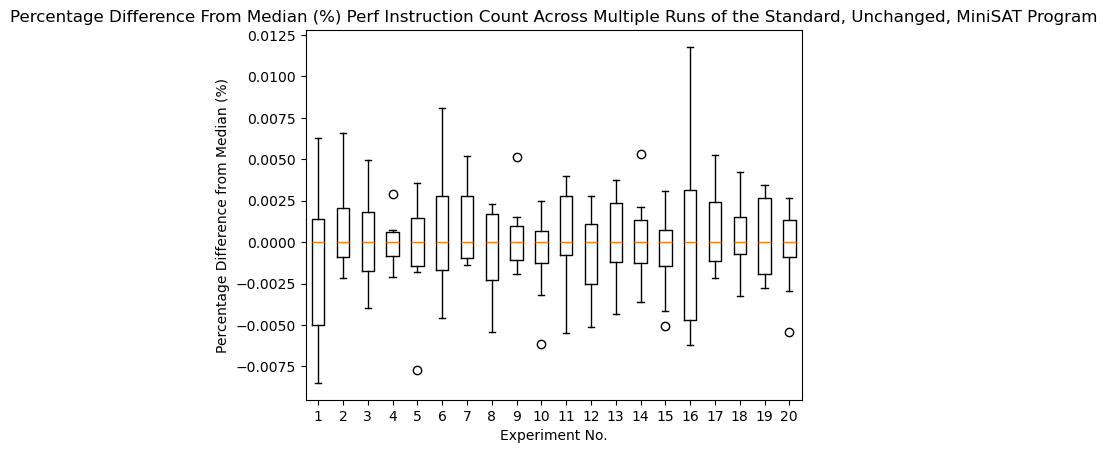

In [59]:
plt.boxplot(df['percentage_diff_from_median'])
plt.title('Percentage Difference From Median (%) Perf Instruction Count Across Multiple Runs of the Standard, Unchanged, MiniSAT Program')
plt.ylabel('Percentage Difference from Median (%)') # Note: each experiment trial has a different train suite 
plt.xlabel('Experiment No.')
plt.show()

### Analyse experiment runs

#### Random Search

We simply compare operators between each other for random search.

In [60]:
unique_rl_algos = df['rl_algorithm'].unique()
unique_rl_algos

array(['ProbabilityMatching', 'EpsilonGreedy', 'UCB', 'UniformSelector'],
      dtype=object)

In [61]:
def compare_rl_algos_as_box_plot(column_name, title, ylabel):
    box_mini_plot = []
    for rl_algo_name in unique_rl_algos:
        rl_algo = df[df['rl_algorithm'] == rl_algo_name]

        values = np.array(rl_algo[column_name])
        box_mini_plot.append(values)
    plt.boxplot(box_mini_plot, labels=unique_rl_algos)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.show()

Efficiency

In [62]:
df['efficiency'] = (df['num_unique_successful_variants_evaluated'] / df['num_unique_variants_evaluated']) * 100

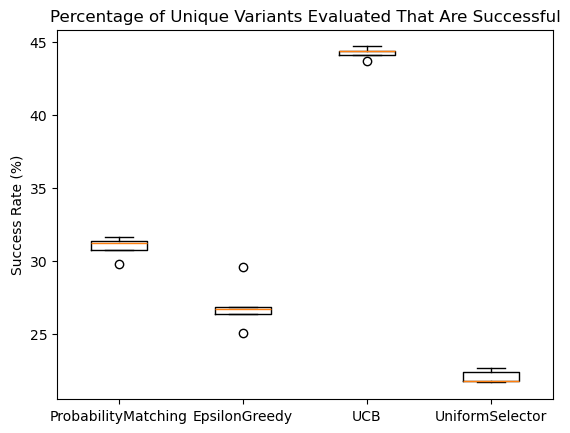

In [63]:
# compare_rl_algos_as_box_plot('successful_runs_percentage', 'Percentage of successful runs for each RL algorithm', 'Percentage of successful runs (%)')
# compare_rl_algos_as_box_plot('num_unique_variants_evaluated', 'Num unique variants evaluated for each RL algorithm', 'Num evaluated variants')
# compare_rl_algos_as_box_plot('num_unique_successful_variants_evaluated', 'Number of Unique Successful Variants for Each RL Algorithm', '# successful variants')
compare_rl_algos_as_box_plot('efficiency', 'Percentage of Unique Variants Evaluated That Are Successful', 'Success Rate (%)')

Efficacy

Of the successful runs, how effective is it at finding runtime improvements?

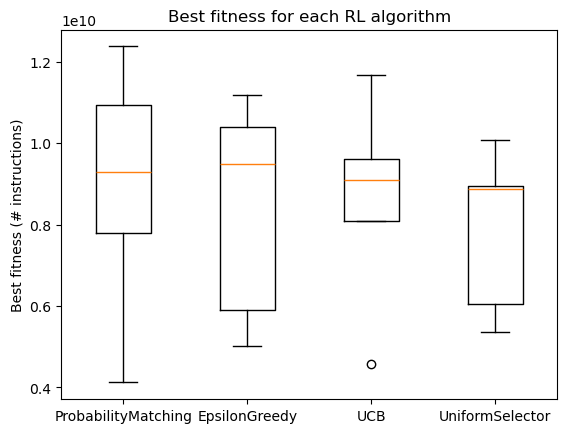

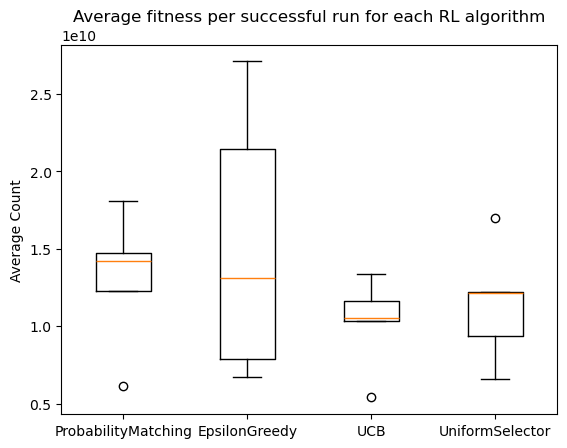

In [64]:
compare_rl_algos_as_box_plot('best_fitness', 'Best fitness for each RL algorithm', 'Best fitness (# instructions)')
# compare_rl_algos_as_box_plot('fitness_decrease_percentage', 'Best fitness decrease percentage for each RL algorithm', 'Fitness decrease percentage (%)')

df['run_times'] = df['pkl_obj'].apply(utils.get_run_times)

# Average runtime per successful run (shows if it learns to be more efficient as well)
df['average_instructions_count_per_successful_run'] = df['run_times'].apply(lambda x: np.mean(x))
compare_rl_algos_as_box_plot('average_instructions_count_per_successful_run', 'Average fitness per successful run for each RL algorithm', 'Average Count')

df['median_instructions_count_per_successful_run'] = df['run_times'].apply(lambda x: np.median(x))
# compare_rl_algos_as_box_plot('median_instructions_count_per_successful_run', 'Median fitness per successful run for each RL algorithm', 'Median Count')


RL Specific (combined efficiency and efficacy)

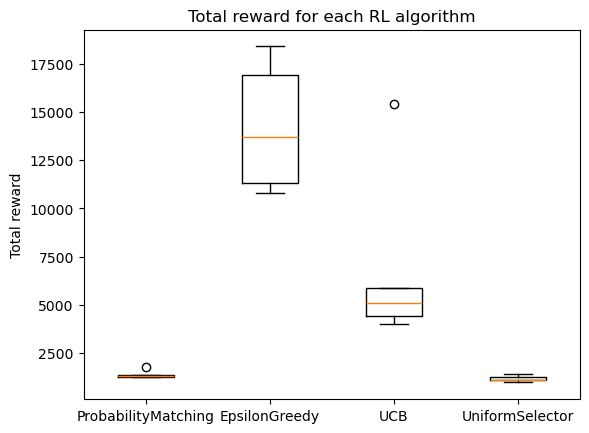

In [65]:
# Total reward (shows how much it could evaluate -- maybe incorporated runtime)
df['total_reward'] = df['rewards'].apply(lambda x: np.sum(x))
compare_rl_algos_as_box_plot('total_reward', 'Total reward for each RL algorithm', 'Total reward')

# Average reward per iteration (would probably favour UCB)
df['average_reward_per_iteration'] = df['rewards'].apply(lambda x: np.mean(x))
# compare_rl_algos_as_box_plot('average_reward_per_iteration', 'Average reward per iteration for each RL algorithm', 'Average reward per iteration')

# Median reward per iteration
df['median_reward_per_iteration'] = df['rewards'].apply(lambda x: np.median(x))
# compare_rl_algos_as_box_plot('median_reward_per_iteration', 'Median reward per iteration for each RL algorithm', 'Median reward per iteration')

Quality vs time

Results for trials of ProbabilityMatching
The results ranked by quality are:


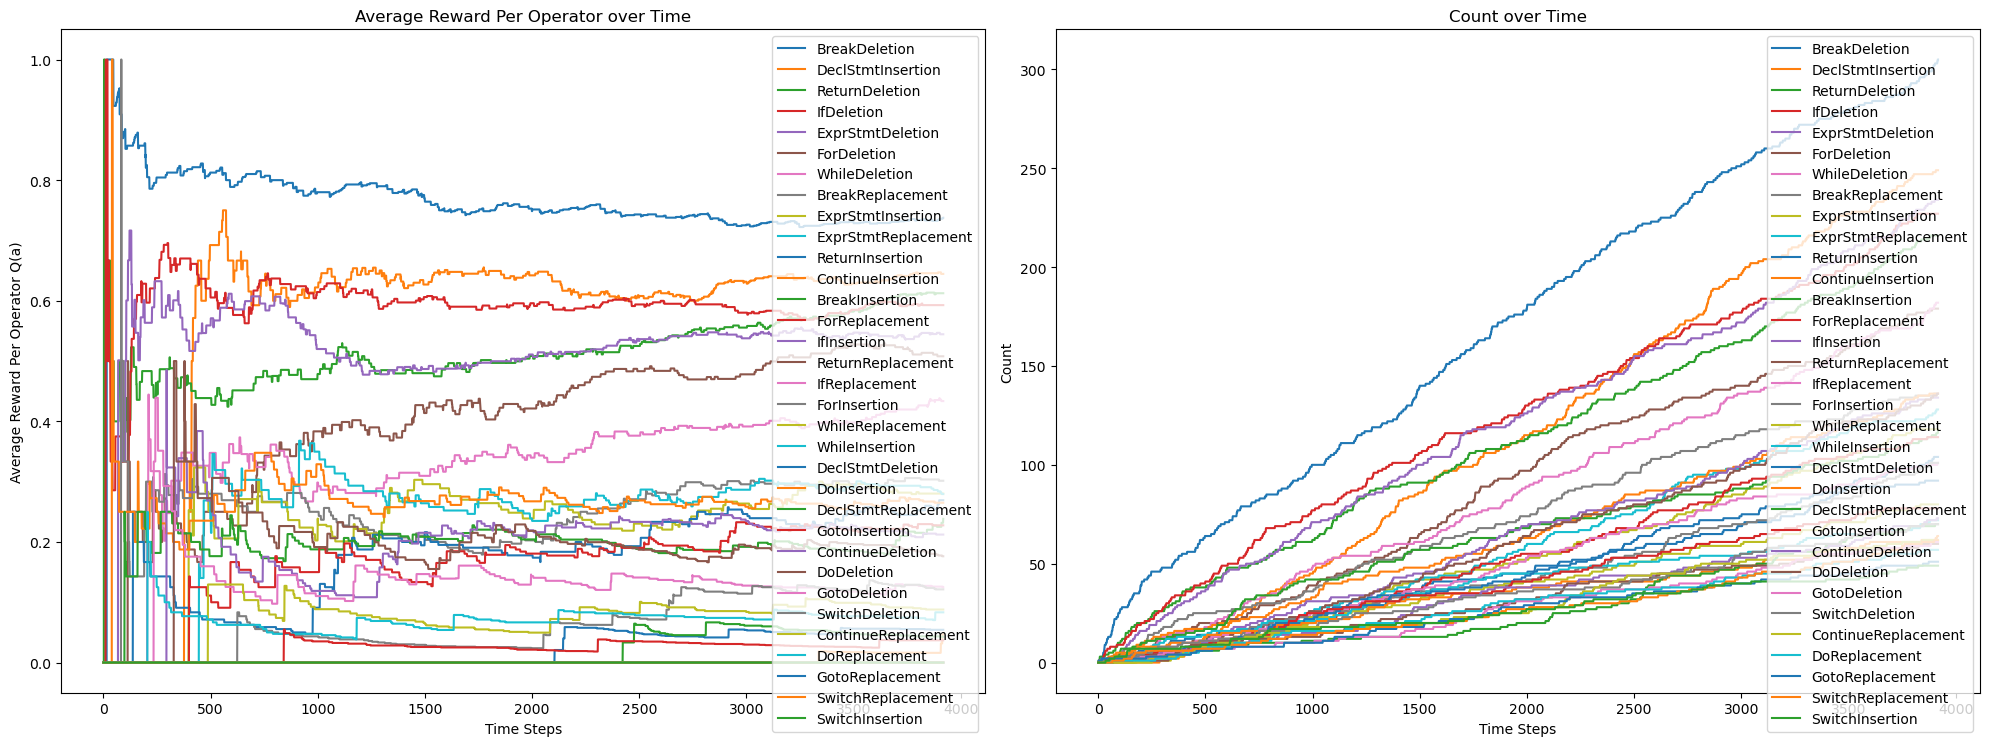

Results for trials of EpsilonGreedy
The results ranked by quality are:


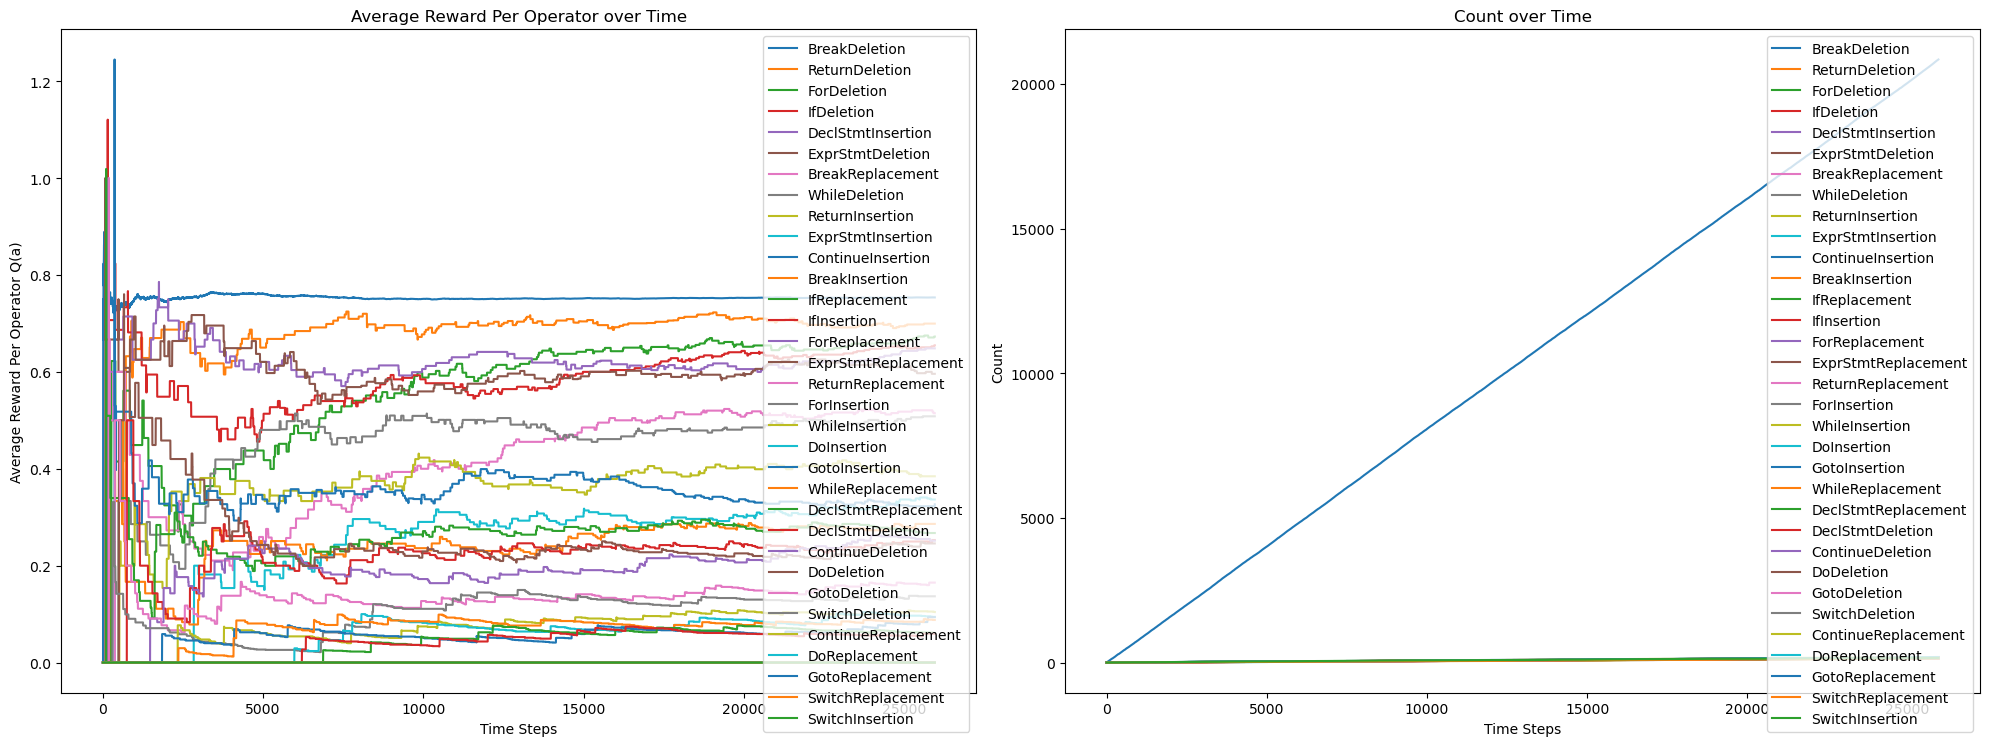

Results for trials of UCB
The results ranked by quality are:


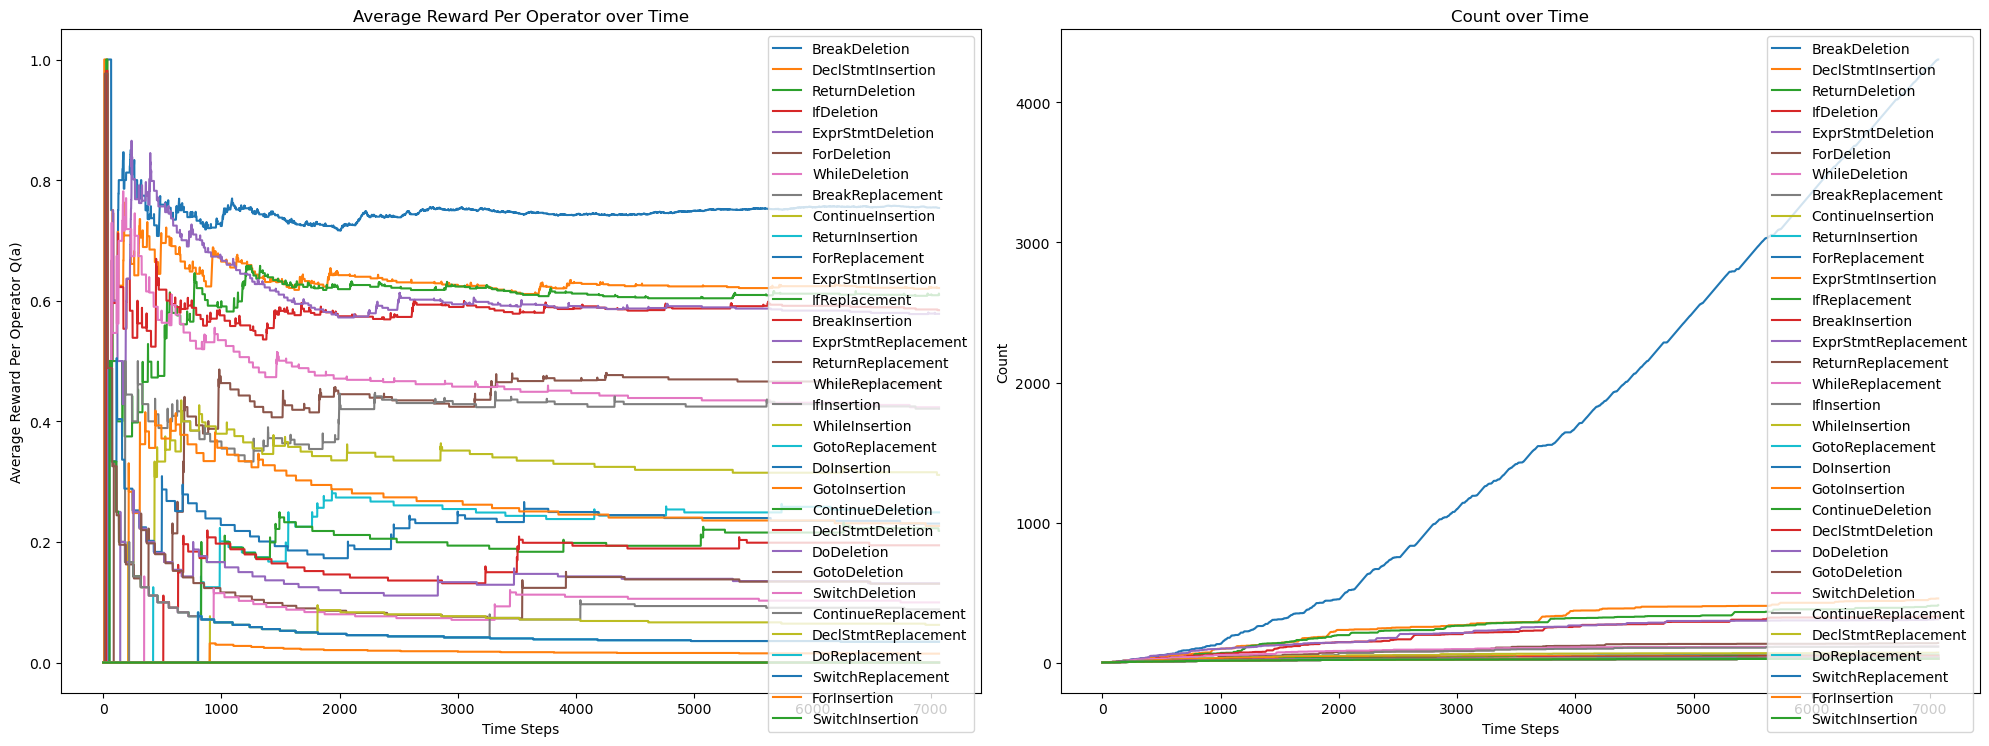

Results for trials of UniformSelector
The results ranked by quality are:


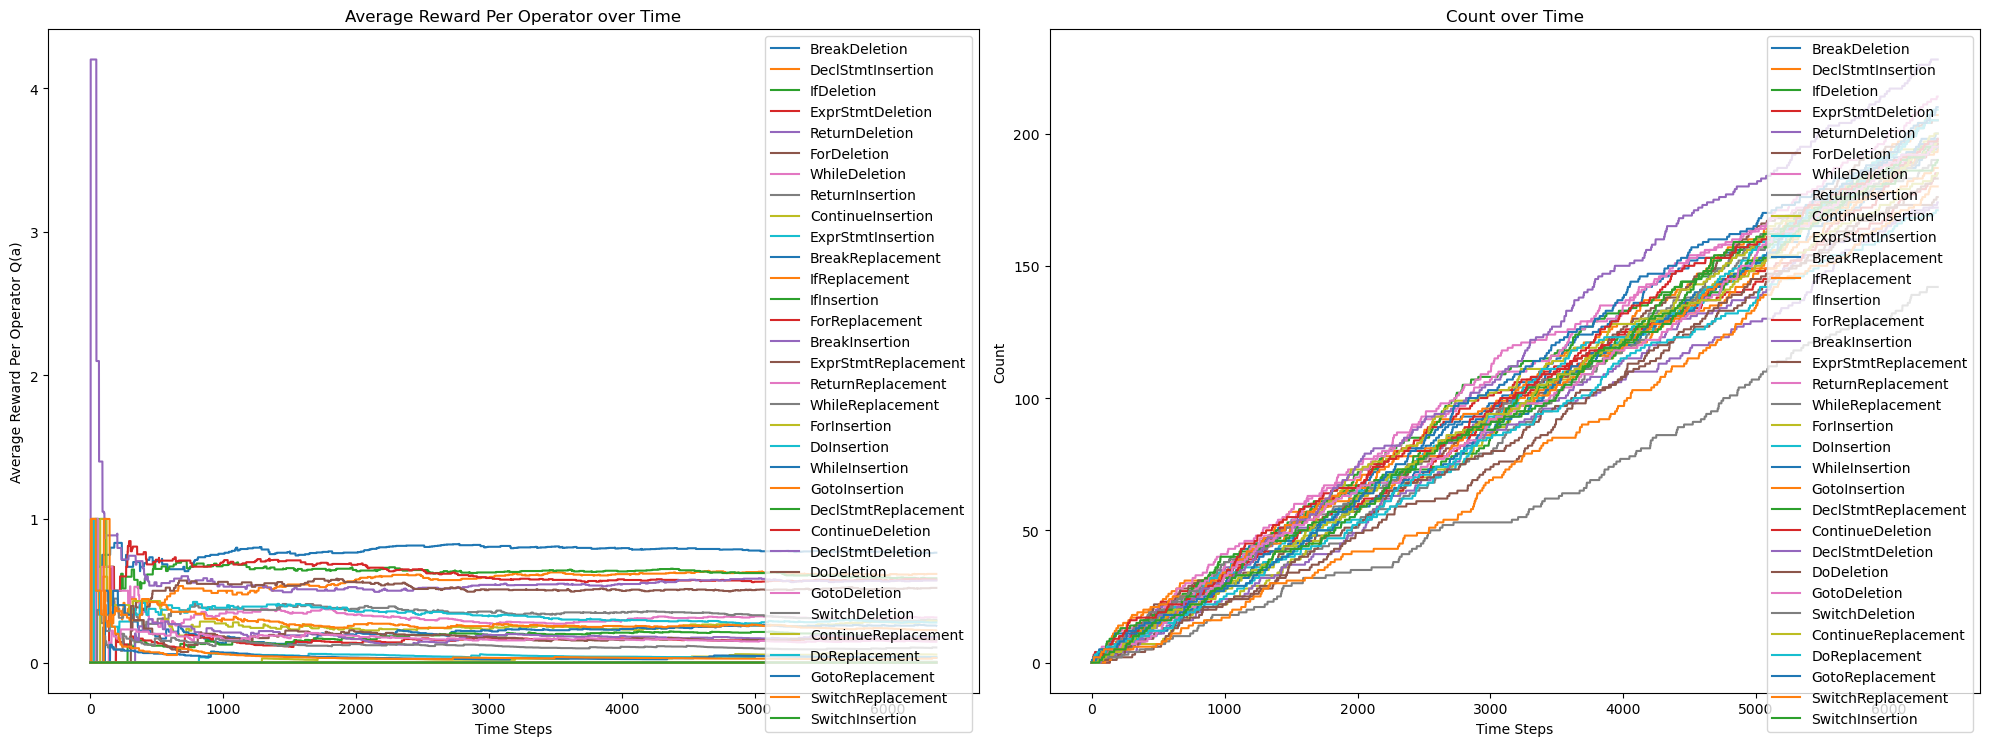

In [66]:
def plot_time_series(ax, series, series_name):
    time_steps = list(range(len(series)))
    ax.plot(time_steps, series)
    ax.set_xlabel('Time Steps')
    ax.set_ylabel(series_name)
    ax.set_title(f'{series_name} over Time')

def plot_rewards_vs_time(ax, op_selector):
    plot_time_series(ax, op_selector.reward_log, 'Rewards')

def plot_quality_vs_time(ax, op_selector):
    operators = sorted(op_selector._operators, key=lambda operator: op_selector.average_qualities_log[-1][operator], reverse=True)
    for operator in operators:
        ax.plot([average_qualities[operator] for average_qualities in op_selector.average_qualities_log], label=f"{operator.__name__}")
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Average Reward Per Operator Q(a)')
    ax.set_title('Average Reward Per Operator over Time')
    ax.legend()

def plot_count_vs_time(ax, op_selector):
    operators = sorted(op_selector._operators, key=lambda operator: op_selector.average_qualities_log[-1][operator], reverse=True)
    for operator in operators:
        ax.plot([action_count[operator] for action_count in op_selector.action_count_log], label=f"{operator.__name__}")
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Count')
    ax.set_title('Count over Time')
    ax.legend()

for rl_algo_name in unique_rl_algos:

    print(f"Results for trials of {rl_algo_name}")
    print("The results ranked by quality are:")

    df_rl = df[df['rl_algorithm'] == rl_algo_name]

    # Makes it only print the first trial
    df_rl = df_rl[df_rl['trial_number'] == '0']
    

    num_rows = len(df_rl)

    fig, axs = plt.subplots(num_rows, 2, figsize=(20, 8 * num_rows)) 
    if num_rows == 1: # Prevent single dimension error
        axs = np.array([axs])

    for trial_num in range(num_rows):
        op_selector = df_rl[df_rl['trial_number'] == str(trial_num)].iloc[0]['pkl_obj']['operator_selector']
        # plot_rewards_vs_time(axs[trial_num, 0], op_selector)
        plot_quality_vs_time(axs[trial_num, 0], op_selector)
        plot_count_vs_time(axs[trial_num, 1], op_selector)

    plt.tight_layout()
    plt.show()


Specific to Policy Gradients

In [67]:
def plot_preferences_vs_time(ax, op_selector):
    assert op_selector.__class__.__name__ == "PolicyGradient"
    for i, operator in enumerate(op_selector._operators):
        ax.plot([preferences[i] for preferences in op_selector._preferences_log], label=f"{operator.__name__}")
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Operator Preference')
    ax.set_title('Preference over Time')
    ax.legend()

def plot_policy_vs_time(ax, op_selector):
    assert op_selector.__class__.__name__ == "PolicyGradient"
    for i, operator in enumerate(op_selector._operators):
        ax.plot([policy[i] for policy in op_selector._policy_log], label=f"{operator.__name__}")
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Operator Probability')
    ax.set_title('Policy over Time')
    ax.legend()

def plot_average_rewards_vs_time(ax, op_selector):
    assert op_selector.__class__.__name__ == "PolicyGradient"
    plot_time_series(ax, op_selector._average_reward_log, 'Average Reward')

for rl_algo_name in unique_rl_algos:

    if rl_algo_name != "PolicyGradient":
        continue

    print(f"Results for trials of {rl_algo_name}")
    df_rl = df[df['rl_algorithm'] == rl_algo_name]

    num_rows = len(df_rl)

    fig, axs = plt.subplots(num_rows, 3, figsize=(40, 8 * num_rows)) 
    if num_rows == 1: # Prevent single dimension error
        axs = np.array([axs])

    for trial_num in range(num_rows):
        op_selector = df_rl[df_rl['trial_number'] == str(trial_num)].iloc[0]['pkl_obj']['operator_selector']
        plot_preferences_vs_time(axs[trial_num, 0], op_selector)
        plot_policy_vs_time(axs[trial_num, 1], op_selector)
        plot_average_rewards_vs_time(axs[trial_num, 2], op_selector)

    plt.tight_layout()
    plt.show()

Others vs time

In [68]:
def plot_together_vs_time(col_name, ylabel, title):
    colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(df['rl_algorithm'].unique()))))

    for rl_algorithm in df['rl_algorithm'].unique():
        color = next(colors)
        df_algorithm = df[df['rl_algorithm'] == rl_algorithm]

        # Loop over the first n rows of df_algorithm
        n = len(df_algorithm)
        for i in range(n):
            if i == 0:
                # Plot the first line and set a label for the legend
                plt.plot(df_algorithm[col_name].iloc[i], color=color, label=rl_algorithm)
            else:
                # Plot the remaining lines without a label to avoid duplicate labels in the legend
                plt.plot(df_algorithm[col_name].iloc[i], color=color)

    plt.xlabel('Time Steps')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

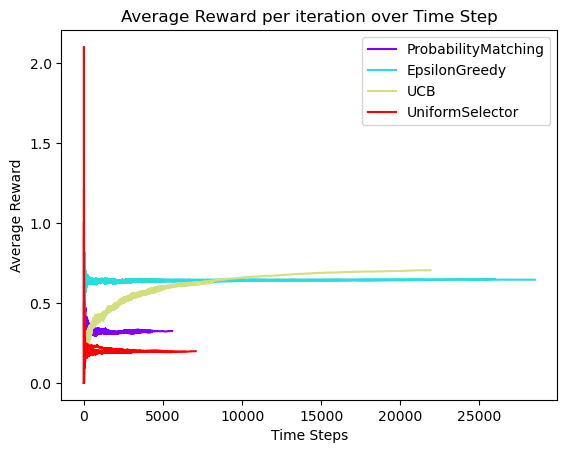

In [69]:
# plot_together_vs_time("cumulative_rewards", "Cumulative Reward", "Cumulative Reward over Time Step")
plot_together_vs_time("average_reward_vs_time", "Average Reward", "Average Reward per iteration over Time Step")

In [70]:
unique_statuses = reduce(set.union, df['get_unique_statuses'])
# unique_statuses

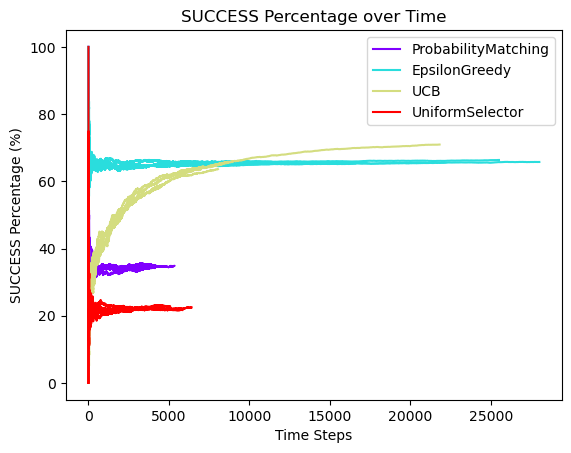

In [71]:
# Generate the relevant columns
for unique_status in unique_statuses:
    df[f"{unique_status}_count_over_time"] = df['pkl_obj'].apply(lambda x: utils.get_status_cum_count(x, unique_status))

for unique_status in unique_statuses:
    df[f"{unique_status}_percentage_over_time"] = df[f"{unique_status}_count_over_time"].apply(lambda cum_array : cum_array * 100 / np.arange(1, len(cum_array) + 1))

for unique_status in ['SUCCESS']:
    # plot_together_vs_time(f"{unique_status}_count_over_time", f"{unique_status} Count", f"{unique_status} Count over Time")
    plot_together_vs_time(f"{unique_status}_percentage_over_time", f"{unique_status} Percentage (%)", f"{unique_status} Percentage over Time") 

## Efficacy: The algorithm which is able to find the best program variant. 

In [72]:
def get_val_logs(path_str):
    path = Path(path_str)
    return str(path.parent / "validate_logs") + "/"

df['path_val_logs'] = df['path_log'].apply(get_val_logs)
df['pkl_obj_val'] = df['path_val_logs'].apply(utils.generate_pickle_object)

df['val_percentage_of_initial'] = df['pkl_obj_val'].apply(lambda obj : obj['run_results'][0]['percentage_of_initial'])
df['val_percentage_of_initial'] 

0           NaN
1     30.704245
2     36.062627
3     30.063638
4           NaN
5           NaN
6     33.929827
7     36.350690
8     32.693678
9     27.244539
10    31.188603
11    31.493073
12    31.901641
13    34.096746
14    36.897083
15    38.095884
16    31.851720
17    37.109350
18          NaN
19          NaN
Name: val_percentage_of_initial, dtype: float64

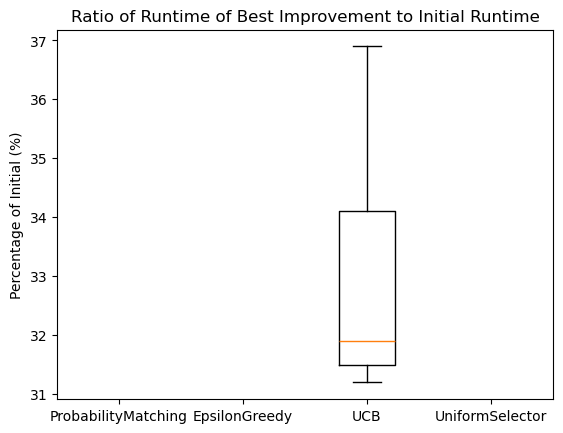

In [73]:
compare_rl_algos_as_box_plot('val_percentage_of_initial', 'Ratio of Runtime of Best Improvement to Initial Runtime', 'Percentage of Initial (%)')

In [74]:
pd.set_option('display.max_colwidth', None)
temp = df[['rl_algorithm', 'trial_number', 'patch']]
temp

rl_algorithm trial_number  \
0   ProbabilityMatching            2   
1   ProbabilityMatching            3   
2   ProbabilityMatching            4   
3   ProbabilityMatching            1   
4   ProbabilityMatching            0   
5         EpsilonGreedy            2   
6         EpsilonGreedy            3   
7         EpsilonGreedy            4   
8         EpsilonGreedy            1   
9         EpsilonGreedy            0   
10                  UCB            2   
11                  UCB            3   
12                  UCB            4   
13                  UCB            1   
14                  UCB            0   
15      UniformSelector            2   
16      UniformSelector            3   
17      UniformSelector            4   
18      UniformSelector            1   
19      UniformSelector            0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                patch  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [75]:
pd.set_option('display.max_colwidth', None)
df['patch']

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

## Number of iterations till we find improved variant

           rl_algorithm  num_till_best
0   ProbabilityMatching           5329
1   ProbabilityMatching           3833
2   ProbabilityMatching           3851
3   ProbabilityMatching           4004
4   ProbabilityMatching           3583
5         EpsilonGreedy           9627
6         EpsilonGreedy           5468
7         EpsilonGreedy          20304
8         EpsilonGreedy           9054
9         EpsilonGreedy          24387
10                  UCB          17154
11                  UCB           8773
12                  UCB           7939
13                  UCB           6337
14                  UCB           5541
15      UniformSelector           6357
16      UniformSelector           5282
17      UniformSelector           4972
18      UniformSelector           4451
19      UniformSelector           5776
                     num_till_best
rl_algorithm                      
EpsilonGreedy               9627.0
ProbabilityMatching         3851.0
UCB                         7939.0
Unifor

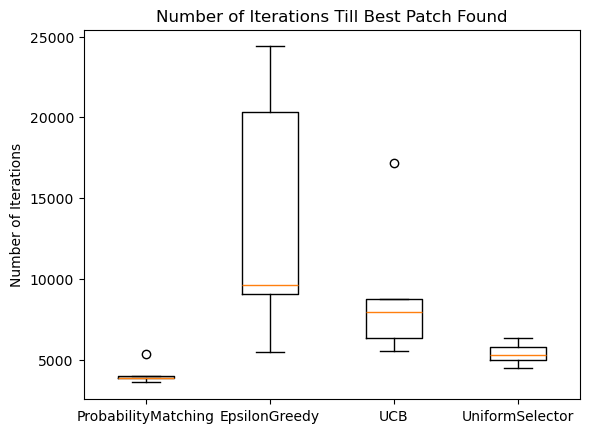

In [76]:
df['num_till_best'] = df.apply(utils.num_iterations_till_patch_found, axis=1)

print(df[['rl_algorithm', 'num_till_best']])
print(df[['rl_algorithm', 'num_till_best']].groupby('rl_algorithm').median())
print(df['num_till_best'].median())

compare_rl_algos_as_box_plot('num_till_best', 'Number of Iterations Till Best Patch Found', 'Number of Iterations')